<a href="https://colab.research.google.com/github/SaiButhongyou/229352-StatisticalLearning/blob/main/Lab05_decision_tree_bagging_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #5

#### Load data at: https://donlapark.pages.dev/229352/heart_disease.csv

* Decision tree ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html))
* Random hyperparameter search using cross-validation ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html))

In [12]:
import pandas as pd
import graphviz

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# import data
data = pd.read_csv("heart_disease.csv", na_values="?")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [13]:

# split into X and y
y = data["label"]
X = data.drop("label", axis=1)

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# impute missing values
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Create a decision tree
clf = DecisionTreeClassifier()

![5CV](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [14]:
params = {'max_depth': [3, 6, 9, 12]}

gridcv = GridSearchCV(clf, params, scoring='accuracy', cv=5)
gridcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 6, 9, 12]}, scoring='accuracy')

In [15]:
gridcv.best_estimator_

DecisionTreeClassifier(max_depth=6)

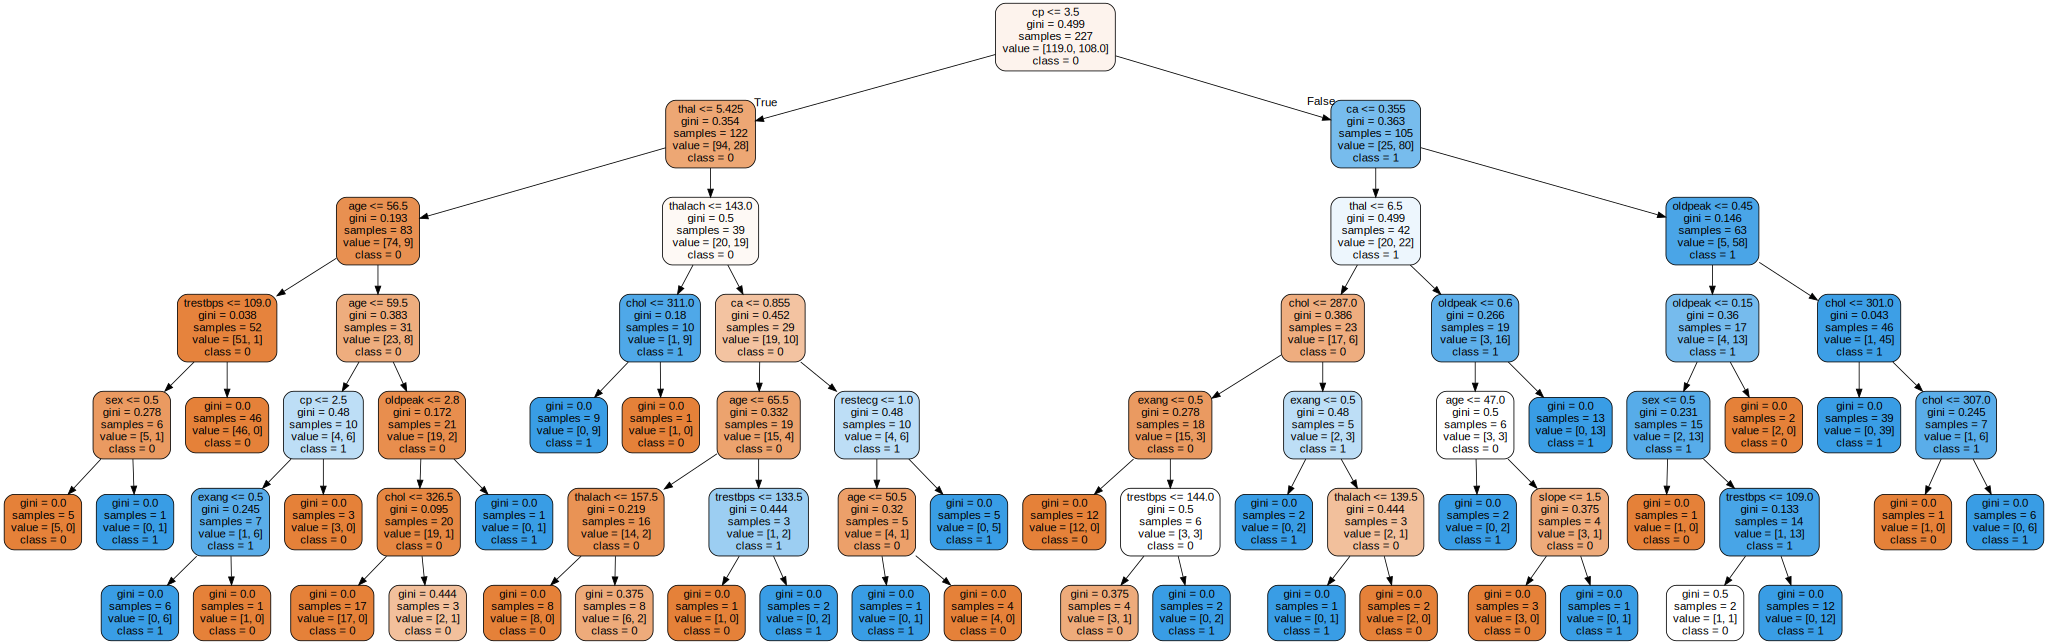

In [16]:
plot_data = export_graphviz(gridcv.best_estimator_,
                            out_file=None,
                            filled=True,
                            rounded=True,
                            feature_names=data.columns[:-1],
                            class_names=['0', '1'])

graph = graphviz.Source(plot_data)
graph

In [17]:
from sklearn.metrics import classification_report

ypred = gridcv.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        45
           1       0.73      0.71      0.72        31

    accuracy                           0.78        76
   macro avg       0.77      0.77      0.77        76
weighted avg       0.78      0.78      0.78        76



## Bagged decision trees
* Bagging classifier ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html))

In [18]:
clf = DecisionTreeClassifier()

bagged_trees = BaggingClassifier(clf, n_estimators=100, max_samples=X_train.shape[0], max_features=5)
bagged_trees.fit(X_train, y_train)
ypred_bt = bagged_trees.predict(X_test)
print(classification_report(y_test, ypred_bt))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        45
           1       0.88      0.74      0.81        31

    accuracy                           0.86        76
   macro avg       0.86      0.84      0.85        76
weighted avg       0.86      0.86      0.85        76



## Random forest classifier
* Random forest ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

In [19]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

#### Exercise
1. Study the hyperparameters of three models: [Decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Bagged Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) and [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. For each model, use pipeline+grid search cross-validation across multiple hyperparameters to find the best model.
* Decision tree: choose at least 3 hyperparameters
* Bagged decision trees: choose at least 3 hyperparameters
* Random forest: choose at least 3 hyperparameters
3. For each model, compute the `f1_macro` and `accuracy` score on the test set.
* What is your best model?
* Plot the best tree model
* What hyperparameters did you choose? (explain in words, not in `sklearn's` parameter name)
* What are the best values of your hyperparameters?

In [28]:
dt_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('clf', DecisionTreeClassifier())
])

dt_param_grid = {
    'clf__max_depth': [3, 5, 10, None],
    'clf__criterion': ['gini', 'entropy'],
    'clf__min_samples_split': [2, 5, 10]
}

dt_grid = GridSearchCV(dt_pipe, dt_param_grid, scoring='f1_macro', cv=5)
dt_grid.fit(X_train, y_train)

print(dt_grid.best_params_)
print(classification_report(y_test, dt_grid.predict(X_test)))

{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.79      0.84      0.82        45
           1       0.75      0.68      0.71        31

    accuracy                           0.78        76
   macro avg       0.77      0.76      0.76        76
weighted avg       0.77      0.78      0.77        76



In [33]:
bag_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('clf', BaggingClassifier(DecisionTreeClassifier()))
])

bag_param_grid = {
    'clf__n_estimators': [10, 50, 100],
    'clf__max_samples': [0.5, 0.8, 1.0],
    'clf__bootstrap': [True, False]
}

bag_grid = GridSearchCV(bag_pipe, bag_param_grid, scoring='f1_macro', cv=5)
bag_grid.fit(X_train, y_train)

print(bag_grid.best_params_)
print(classification_report(y_test, bag_grid.predict(X_test)))

{'clf__bootstrap': True, 'clf__max_samples': 0.5, 'clf__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.86      0.93      0.89        45
           1       0.89      0.77      0.83        31

    accuracy                           0.87        76
   macro avg       0.87      0.85      0.86        76
weighted avg       0.87      0.87      0.87        76



In [34]:
rf_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('clf', RandomForestClassifier())
])

rf_param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__max_depth': [5, 10, None]
}

rf_grid = GridSearchCV(rf_pipe, rf_param_grid, scoring='f1_macro', cv=5)
rf_grid.fit(X_train, y_train)

print(rf_grid.best_params_)
print(classification_report(y_test, rf_grid.predict(X_test)))

{'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__n_estimators': 300}
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        45
           1       0.85      0.74      0.79        31

    accuracy                           0.84        76
   macro avg       0.84      0.83      0.83        76
weighted avg       0.84      0.84      0.84        76



In [32]:
from sklearn.metrics import f1_score, accuracy_score

models = {
    "Decision Tree": dt_grid,
    "Bagged Trees": bag_grid,
    "Random Forest": rf_grid
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results[name] = {"Accuracy": acc, "F1-Macro": f1}
    print(f"{name}: Accuracy = {acc:.4f}, F1-Macro = {f1:.4f}")


Decision Tree: Accuracy = 0.7763, F1-Macro = 0.7645
Bagged Trees: Accuracy = 0.8553, F1-Macro = 0.8456
Random Forest: Accuracy = 0.8553, F1-Macro = 0.8476


What is your best model?

Random Forest: Accuracy = 0.8553, F1-Macro = 0.8476

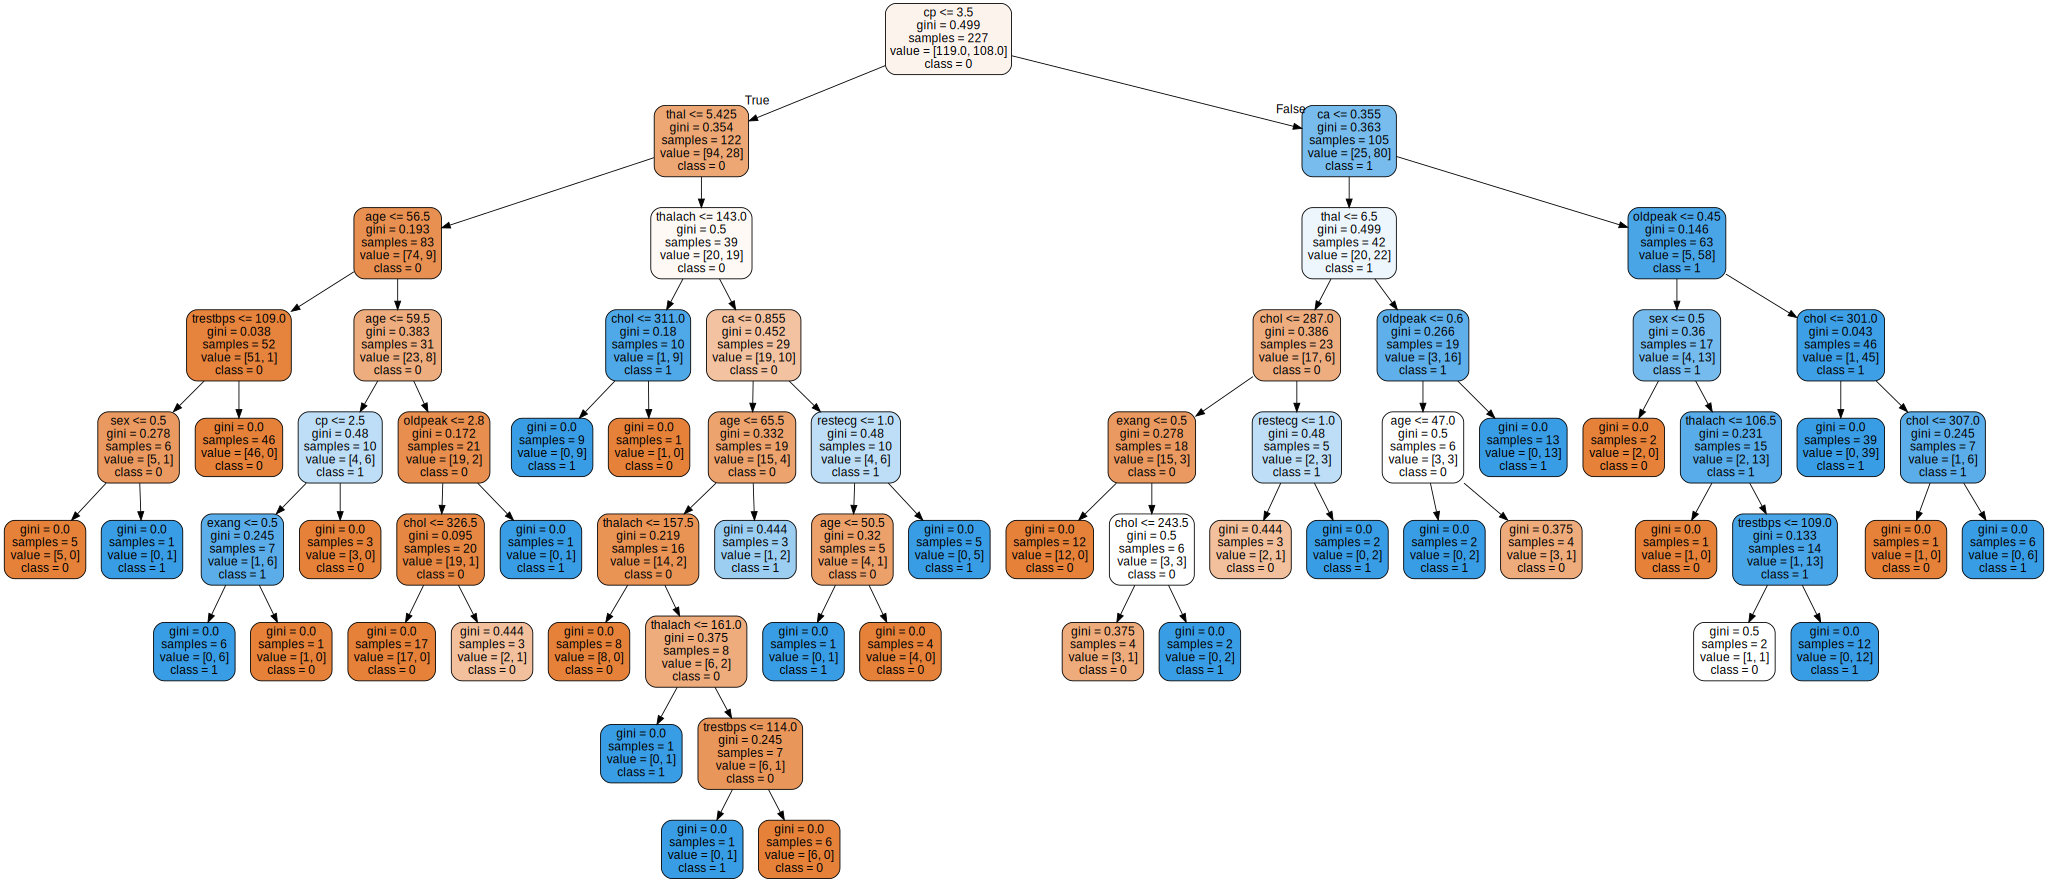

In [36]:
best_dt_model = dt_grid.best_estimator_.named_steps['clf']

plot_data = export_graphviz(best_dt_model,
                            out_file=None,
                            filled=True,
                            rounded=True,
                            feature_names=data.columns[:-1],
                            class_names=['0', '1'])

graph = graphviz.Source(plot_data)
graph

1. Decision Tree

Maximum Depth: เพื่อไม่ให้ต้นไม้แตกแยกกิ่งจนละเอียดเกินไป

Criterion: เพื่อเปรียบเทียบว่า Gini หรือ Entropy หาจุดตัดที่ดีที่สุด

Minimum Samples Split: เพื่อให้โมเดลมีความยืดหยุ่น


2. Bagged Decision Trees

Number of Estimators :

Max Samples : เพื่อให้ต้นไม้แต่ละต้นเห็นข้อมูลที่ไม่เหมือนกัน

Bootstrap: เพื่อให้มีความหลากหลายของต้นไม้ในกลุ่ม


3. Random Forest

Max Features: เพื่อไม่ให้ต้นไม้มีข้อมูลซ้ำกัน

Number of Trees: ควบคุมไม่ให้จำนวนต้นไม้เยอะ

Max Depth: ควบคุมไม่ให้โมเดลซับซ้อนจนเกินจำเป็น

In [37]:
print(dt_grid.best_params_)
print(bag_grid.best_params_)
print(rf_grid.best_params_)

{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 5}
{'clf__bootstrap': True, 'clf__max_samples': 0.5, 'clf__n_estimators': 100}
{'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__n_estimators': 300}
